In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.init import kaiming_uniform_
from torch.distributions import Normal
from scipy.ndimage.filters import uniform_filter1d
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count
import time
import gym

In [3]:
class ReplayMemory():
    def __init__(self,capacity):   
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count+=1
    
    def sample(self, batch_size):
        return rand.sample(self.memory,batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size
    
    def update_td_error(self, sampled_experiences):
        for sampled_idx,sampled_exp in enumerate(sampled_experiences):
            for mem_idx, mem_exp in enumerate(self.memory):
                if mem_exp.timestep == sampled_exp.timestep:
                    self.memory[mem_idx] = sampled_exp #update memory
                    break
        
    def get_memory_values(self):
        return self.memory    

In [4]:
def extract_tensors(experiences):
    #print(".....................................................")
    #print(experiences)
    batch = Xp(*zip(*experiences))
    state = np.stack(batch.state) #stack
    action = np.stack(batch.action)
    next_state = np.stack(batch.next_state)
    reward = np.stack(batch.reward)
    done = np.stack(batch.done)
    abs_td_error = np.stack(batch.abs_td_error)
    timestep = np.stack(batch.timestep)
    return state,action,next_state,reward,done,abs_td_error,timestep

In [5]:
def rebuild_experiences(state, action, next_state, reward, done, abs_error, timestep):
    exp_list = []
    for idx_ in range(len(state)):
        exp_list.append(\
                        Xp(state[idx_], action[idx_], next_state[idx_], reward[idx_],\
                           done[idx_], abs_error[idx_], timestep[idx_]))
    return exp_list

In [6]:
from collections import namedtuple
Xp = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done', 'abs_td_error','timestep'))
Xp_points = Xp(5,6,7,8,9,10,11)
Xp_points

Experience(state=5, action=6, next_state=7, reward=8, done=9, abs_td_error=10, timestep=11)

In [7]:
class linearApproximator_FCGSAP(nn.Module):
    def __init__(self,state_shape,outputs,hidden_dims=(32,32), log_entropy_lr =0.001,\
                log_std_dev_min=-20, log_std_dev_max= 2):
        super(linearApproximator_FCGSAP, self).__init__()
        self.input_size = state_shape
        self.out = outputs
        self.log_std_dev_min = log_std_dev_min
        self.log_std_dev_max = log_std_dev_max
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                   else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(\
                                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer_distribution  = nn.Linear(hidden_dims[-1],self.out)
        self.output_layer_mean = nn.Linear(hidden_dims[-1],self.out)
        self.target_entropy = -np.prod(self.out)
        self.log_alpha = torch.zeros(1,\
                                     requires_grad=True,\
                                     device = self.device)
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],\
                                                    lr=log_entropy_lr)
                                     
        self.to(self.device)
        
    def forward(self, state_shape):
        if not isinstance(state_shape, torch.Tensor):
            state_shape = torch.tensor(state_shape, dtype=torch.float32)
        state_shape = state_shape.to(self.device)
        x = self.fc1(state_shape)
        x = F.relu(x)
        
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        
        distribution = self.output_layer_distribution(x)#logits, preferences of actions
        distribution = torch.clamp(distribution,\
                                   self.log_std_dev_min,\
                                   self.log_std_dev_max)
        mean   = self.output_layer_mean(x)
        return mean, distribution
        
    def full_pass(self, state, epsilon = 1e-7):
        mean, distribution = self.forward(state)
        pi_s = Normal(mean, distribution.exp())
        pre_sampled_actions = pi_s.rsample()
        sampled_actions = torch.tanh(pre_sampled_actions)#scale actions between -1 and 1
        #we also rescale our logprobs to match action space
        log_probs = pi_s.log_prob(pre_sampled_actions) - torch.log(\
                                    (1 - sampled_actions.pow(2)).clamp(0,1) + epsilon)
                                                
        log_probs = log_probs.sum(dim=1, keepdim=True)
        return sampled_actions, log_probs, mean

In [8]:
class linearApproximator_FCQV(nn.Module):#Q value of state action pair
    def __init__(self,state_shape,action_outputs_size,hidden_dims=(32,32)):
        super(linearApproximator_FCQV, self).__init__()
        self.input_size = state_shape
        self.action_outputs_size = action_outputs_size
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                   else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_input_layer = hidden_dims[i]
            if i == 0:
                hidden_input_layer += self.action_outputs_size #increased to account for size/number of actions
            hidden_layer = nn.Linear(\
                                hidden_input_layer, hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer  = nn.Linear(hidden_dims[-1],1)
        self.to(self.device)
        
    def forward(self, state_shape, action_shape):
        if not isinstance(state_shape, torch.Tensor):
            state_shape = torch.tensor(state_shape, dtype=torch.float32).to(self.device)
        if not isinstance(action_shape, torch.Tensor):
            action_shape = torch.tensor(action_shape, dtype=torch.float32).to(self.device)
                    
        x = self.fc1(state_shape)
        x = F.relu(x)
        
        for idx, hidden_layer in enumerate(self.hidden_layers):
            if idx == 0:
                x = torch.cat((x, action_shape), dim=1)
            x = F.relu(hidden_layer(x))
        
        q_value = self.output_layer(x)#logits, preferences of actions
        return q_value

In [9]:
def update_networks(online_q_network_a, online_q_network_b,\
                    offline_q_network_a, offline_q_network_b, tau):
        
    for target_weights, online_weights in zip(offline_q_network_a.parameters(), online_q_network_a.parameters()):
        target_weight_update = (1.0 - tau)*target_weights.data
        online_weight_update = tau*online_weights.data
        sum_up = target_weight_update + online_weight_update
        target_weights.data.copy_(sum_up)
        
    for target_weights, online_weights in zip(offline_q_network_b.parameters(), online_q_network_b.parameters()):
        target_weight_update = (1.0 - tau)*target_weights.data
        online_weight_update = tau*online_weights.data
        sum_up = target_weight_update + online_weight_update
        target_weights.data.copy_(sum_up)

    return offline_q_network_a, offline_q_network_b

In [10]:
def prioritize_samples(experience_samples, alpha, beta):
    state,action,next_state,reward,done,abs_td_error,timesteps \
                            = extract_tensors(experience_samples)
    abs_td_error, indices_ = (list(t) for t in zip(*sorted(\
                            zip(abs_td_error.tolist(), timesteps))))
    abs_td_error.reverse()
    indices_.reverse()#reverse to march sort func
    abs_td_error = np.array(abs_td_error)
    abs_td_error  = torch.tensor(abs_td_error)
    ranks = np.arange(1, len(abs_td_error)+1)
    priorities = 1.0/ranks
    priorities = priorities**alpha
    priorities = np.expand_dims(priorities, axis=1)
    probabilities = priorities/np.sum(priorities, axis=0)
    assert np.isclose(probabilities.sum(), 1.0)
    number_of_samples  = len(probabilities)
    weight_importance_ = number_of_samples*probabilities
    weight_importance_ = weight_importance_**-beta
    weight_importance_max = np.max(weight_importance_)
    weight_importance_scaled = weight_importance_/weight_importance_max
    return weight_importance_scaled, indices_ 

In [11]:
def update_online_model(experience_samples,\
                        online_policy_network, online_q_network_a, online_q_network_b,\
                        online_policy_optimizer, online_q_optimizer_a, online_q_optimizer_b,\
                        offline_q_network_a, offline_q_network_b,\
                        gamma, weighted_importance,\
                        timestep_indices):
    
    states, actions, next_states, rewards, done, td_errors, timesteps = extract_tensors(experience_samples)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #rearrange first
    #need to find indexes of timestep indexes in timestep.
    #then rearrange according to those indexes
    sort_values = [timesteps.tolist().index(i) for i in timestep_indices]
    states = states[sort_values,:]
    states = np.squeeze(states)
    actions = actions[sort_values]
    next_states = next_states[sort_values,:]
    next_states = np.squeeze(next_states)
    rewards = rewards[sort_values]
    done = done[sort_values]
    td_errors = td_errors[sort_values]
    timesteps = timesteps[sort_values] 
    
    
    states = torch.tensor(states).float().to(device)
    actions = torch.tensor(actions)
    actions = actions.float().to(device)
    next_states=torch.tensor(next_states).float().to(device)
    rewards = torch.tensor(rewards).float().to(device)
    rewards = rewards.unsqueeze(1)
    done = torch.tensor(done).float().to(device)
    done = done.unsqueeze(1)
    weighted_importance = torch.tensor(weighted_importance).float().to(device)
    
    
    current_actions,log_pi, _ = online_policy_network.full_pass(states)
    target_alpha = (log_pi +\
                    online_policy_network.target_entropy).detach()
    
    target_alpha_loss = -(online_policy_network.log_alpha *\
                         target_alpha).mean()
    
    online_policy_network.log_alpha_optimizer.zero_grad()
    target_alpha_loss.backward()
    online_policy_network.log_alpha_optimizer.step()
    optimized_alpha = online_policy_network.log_alpha.exp()
    
    
    max_q_sa_online_a = online_q_network_a(states,\
                                           current_actions.detach())
    max_q_sa_online_b = online_q_network_b(states,\
                                           current_actions.detach())
    max_q_online__ = torch.min(max_q_sa_online_a,\
                               max_q_sa_online_b)
    
    policy_loss = -(max_q_online__.detach()\
                    - optimized_alpha*log_pi).mean()#policy loss
    
    predicted_online_action_policy,\
                log_pi_ns, _ = online_policy_network.full_pass(next_states)
    max_q_sa_offline_a = offline_q_network_a(next_states,\
                                predicted_online_action_policy)
    max_q_sa_offline_b = offline_q_network_b(next_states,\
                                predicted_online_action_policy)
    max_q_sa_offline = torch.min(max_q_sa_offline_a,\
                                 max_q_sa_offline_b)
    
    max_q_sa_offline = max_q_sa_offline - optimized_alpha*log_pi_ns
    TWIN_target = max_q_sa_offline
    #print("w_i: ", weighted_importance,weighted_importance.shape)
    #print("rwd: ", rewards,rewards.shape)
    #print("abs: ", td_errors,td_errors.shape)
    TWIN_target = TWIN_target.detach()
    TWIN_target *=(1 - done)
    TWIN_target = rewards + gamma*TWIN_target
    TWIN_target*=weighted_importance.detach()
    TWIN_target = TWIN_target.detach()
    loss_func = torch.nn.SmoothL1Loss()
    
    
    q_sa_online_a = online_q_network_a(states, actions)
    q_sa_online_a*=weighted_importance.detach()
    q_sa_online_b = online_q_network_b(states, actions)
    q_sa_online_b*=weighted_importance.detach()
    
    #update errors
    abs_a = (TWIN_target - q_sa_online_a.detach())
    abs_b = (TWIN_target - q_sa_online_b.detach())
    ovr_abs_update = torch.min(abs_a, abs_b)
    ovr_abs_update = np.absolute(ovr_abs_update.detach().cpu().numpy())
    
    
    q_online_value_loss_a = loss_func(q_sa_online_a,\
                                             TWIN_target.detach())
    q_online_value_loss_b = loss_func(q_sa_online_b,\
                                             TWIN_target.detach())
    online_q_optimizer_a.zero_grad()
    q_online_value_loss_a.backward()
    online_q_optimizer_a.step()
    
    online_q_optimizer_b.zero_grad()
    q_online_value_loss_b.backward()
    online_q_optimizer_b.step()
    
    online_policy_optimizer.zero_grad()
    policy_loss.backward()
    online_policy_optimizer.step()
        
    states, actions, next_states, rewards, done, td_errors, timesteps = extract_tensors(experience_samples)
    experiences_rebuilded = rebuild_experiences(states, actions, next_states, rewards, done, ovr_abs_update, timesteps)
    return experiences_rebuilded

In [12]:
def query_error(online_policy_network, offline_q_network_a, offline_q_network_b,\
                online_q_network_a, online_q_network_b, state, action, next_state, reward, gamma):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state = torch.tensor(state).float().to(device)
    state = state.unsqueeze(0)
    next_state = torch.tensor(next_state).float().to(device)
    next_state = next_state.unsqueeze(0)
    alpha = online_policy_network.log_alpha.exp()
    ns_actions,log_pi_ns, _ = online_policy_network.full_pass(next_state)
    q_target_next_states_action_a = offline_q_network_a(next_state,\
                                                    ns_actions.detach())
    q_target_next_states_action_b = offline_q_network_b(next_state,\
                                                    ns_actions.detach())
    TWIN_target = torch.min(q_target_next_states_action_a, q_target_next_states_action_b)
    TWIN_target = TWIN_target - alpha * log_pi_ns
    TWIN_target = reward + (gamma*TWIN_target.detach())
    action = np.expand_dims(action, axis=0)
    q_online_state_action_val_a = online_q_network_a(state, action)
    q_online_state_action_val_b = online_q_network_b(state, action)
    abs_a = (TWIN_target - q_online_state_action_val_a)
    abs_b = (TWIN_target - q_online_state_action_val_b)
    abs_stack = torch.min(abs_a, abs_b)
    ovr_abs_update = abs_stack
    return np.absolute(ovr_abs_update.detach().cpu().numpy())

In [13]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [14]:
def select_action(state, online_policy_network, env, warm_up, batch_size, memory):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(state).float().to(device)
    state = state.unsqueeze(0)
    warm_up_action = batch_size * warm_up
    if memory.can_provide_sample(warm_up_action) == False:
        action = np.random.uniform(low=env.action_space.low, high=env.action_space.high)
        action = action.reshape(env.action_space.high.shape)
    else:
        with torch.no_grad():
            mean,log_std = online_policy_network.forward(state)
            action = torch.tanh(Normal(mean, log_std.exp()).sample())
            action = action.detach().cpu().numpy().reshape(env.action_space.high.shape)
            #print("action: ",action)
    return action

In [15]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().detach().cpu().numpy())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [16]:
def SAC_PER(env,
         gamma=0.99,
         alpha_pr=0.3,
         beta_pr=0.6,
         memory_size = 50000,
         tau = 0.001,
         offline_update = 1,
         min_sample_size=400,
         batch_size = 64,
         n_ep=200,
         max_steps = 100000,
         max_steps_per_ep = 500,
         warm_up=50
         ):
    
    
    observation_space = len(env.reset())
    action_space_high, action_space_low = env.action_space.high, env.action_space.low
    n_actions = len(action_space_high)
    online_policy_network = linearApproximator_FCGSAP(observation_space,n_actions,\
                                     hidden_dims=(256,256))
    online_q_network_a = linearApproximator_FCQV(observation_space,\
                                     n_actions,hidden_dims=(256,256))
    online_q_network_b = linearApproximator_FCQV(observation_space,\
                                     n_actions,hidden_dims=(256,256))
    
    offline_q_network_a = linearApproximator_FCQV(observation_space,\
                                     n_actions,hidden_dims=(256,256))
    offline_q_network_b = linearApproximator_FCQV(observation_space,\
                                     n_actions,hidden_dims=(256,256))
    

    offline_q_network_a.eval()
    offline_q_network_a = freeze_model(offline_q_network_a)
    offline_q_network_b.eval()
    offline_q_network_b = freeze_model(offline_q_network_b)
    
    online_policy_optimizer    = torch.optim.Adam(online_policy_network.parameters(),lr=0.0003)
    online_q_optimizer_a = torch.optim.Adam(online_q_network_a.parameters(),lr=0.0005)
    online_q_optimizer_b = torch.optim.Adam(online_q_network_b.parameters(),lr=0.0005)
    
    memory = ReplayMemory(memory_size)
    
    t_step = 0 #important
    reward_per_ep = []
    
    
    for e in tqdm(range(n_ep)):
        state = env.reset()
        reward_accumulated = 0
        
        while True:
            env.render()
            action = select_action(state, online_policy_network, env, warm_up, batch_size, memory)
            #if memory.can_provide_sample(min_sample_size):
                #print(action)
            next_state, reward, done, info = env.step(action)
            td_error = query_error(online_policy_network, offline_q_network_a, offline_q_network_b,\
                                online_q_network_a, online_q_network_b,\
                                state, action, next_state, reward, gamma)
            td_error = np.squeeze(td_error, axis = 0)
            reward_accumulated+=reward
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
           
            memory.push(Xp(state, action, next_state, reward, is_failure, td_error, t_step))
            state = next_state
            t_step+=1
            if memory.can_provide_sample(min_sample_size):
                experience_samples = memory.sample(batch_size)
                weighted_importance, indices = prioritize_samples(experience_samples, alpha_pr, beta_pr)
                rebuilded_exp = update_online_model(experience_samples,\
                        online_policy_network, online_q_network_a, online_q_network_b,\
                        online_policy_optimizer, online_q_optimizer_a, online_q_optimizer_b,\
                        offline_q_network_a, offline_q_network_b,\
                        gamma, weighted_importance, indices)
                memory.update_td_error(rebuilded_exp)
                
            if t_step%offline_update == 0:
                offline_q_network_a, offline_q_network_b = update_networks(online_q_network_a, online_q_network_b,\
                                                                    offline_q_network_a, offline_q_network_b, tau)
            if done == True:
                reward_per_ep.append(reward_accumulated)
                break
            if t_step % max_steps_per_ep == 0:
                #plot_grad_flow(online_policy_network.named_parameters())
                break
            if t_step > max_steps:
                env.close()
                return reward_per_ep
    env.close()           
    return online_policy_network,reward_per_ep

In [63]:
env = gym.make('BipedalWalker-v3')

In [66]:
env.close()

In [65]:
pn, rewards = SAC_PER(env)

  0%|          | 0/2000 [00:03<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
arr = uniform_filter1d(rewards, size=5)

In [ ]:
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

In [ ]:
plt.plot(y, x)

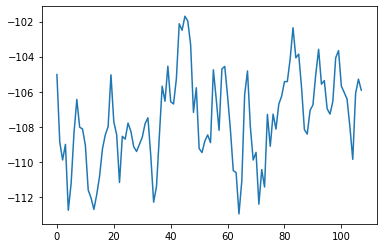

In [80]:
plt.plot(y, x)

In [5]:
2**0.5

1.4142135623730951

In [23]:
a_list = [1, 2, 3]

position_of_three = a_list.index(3)

print(position_of_three)

2


In [25]:
[a_list.index(i) for i in a_list]

[0, 1, 2]